In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import seaborn as sn
from pylab import subplot,imshow
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchinfo import summary

import pytorch_lightning as pl

cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256)))

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#5D80AE', '#FC5758', '#0DD77D', '#FFC507', '#F64044', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [4]:
class History:
    """Accumulates values in a dictionary of sequences."""
    def __init__(self, keys):
        self.data = {}
        self.keys = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args):
        for k,a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self):
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d):
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k):
        return self.data


def displayData(X, t, rows=10, cols=10, img_ind=None, size =8, class_value = False):
    X = X.numpy()
    t = t.numpy()
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 10, color=colors[4])
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off') 
    plt.subplots_adjust(top=1)
    plt.show()


def plotData(X, Y, c, npixel=28):
    X = X.numpy()
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()


def save_model_coeffs(m,filename):
    torch.save(m.state_dict(), filename)
    print("Saved model coefficients to disk")


def load_model_coeffs(m, filename):
    m.load_state_dict(torch.load(filename))
    print("Model coefficients loaded from disk")

In [5]:
def accuracy(preds, targets):  #@save
    """Compute the number of correct predictions."""
    # deal with the case when an array of probabilities is predict, by deriving the highest-probability class
    if len(preds.shape) > 1 and preds.shape[1] > 1:
        preds = preds.argmax(axis=1)
    cmp = preds.type(targets.dtype) == targets
    return float(cmp.type(targets.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        # Set the model to eval mode
        net.eval()
    h_test = History(['correct_predictions', 'predictions'])  # No. of correct predictions, no. of predictions
    with torch.no_grad(): # Gradients must not be computed
        count = 0
        for X, y in data_iter:
            count += 1
            if count%10 == 0:
                print('x', end='')
            #X = X.flatten(start_dim=1, end_dim=-1)
            h_test.add(accuracy(net(X), y), len(y))
        s = h_test.sums()
    print(' ')
    return s['correct_predictions']/s['predictions']


def train_epoch(model, train_iter, loss_func, optimizer): 
    if isinstance(model, torch.nn.Module):
        model.train()  # Set the model to training mode
    h_epoch = History(['loss', 'correct_predictions', 'n_examples']) # Training loss, no. of correct predictions, no. of examples
    count = 0
    for X, y in train_iter:
        count += 1
        if count%10 == 0:
            print('.', end='')
        #X=X.flatten(start_dim=1, end_dim=-1)
        # Compute predictions
        y_hat = model(X)
        # Compute loss
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        h_epoch.add(float(loss), accuracy(y_hat, y), len(y))
    # Return training loss and training accuracy
    s = h_epoch.sums()
    return s['loss']/s['n_examples'], s['correct_predictions']/s['n_examples'], h_epoch


def train(net, loaders, loss_func, num_epochs, updater, report=False):
    h_batch = History(['loss', 'correct_predictions', 'n_examples'])
    h_train = History(['training_loss', 'training_accuracy', 'test_accuracy']) # Avg. training loss, avg. training accuracy, test accuracy
    for epoch in range(num_epochs):
        print(f'Epoch #{epoch+1}')
        # train model for one epoch
        train_loss, train_acc, h_epoch = train_epoch(net, loaders['train'], loss_func, updater)
        # evaluate accuracy on test set
        test_acc = evaluate_accuracy(net, loaders['test'])
        if report:
            print(f' Loss {train_loss:3.4f}, Training set accuracy {train_acc:1.4f}, Test set accuracy {test_acc:1.4f}')
        else:
            print('\n')
        h_train.add(train_loss, train_acc, test_acc)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch


def predict(net, loaders):
    preds_train = []
    y_train = []
    preds_test = []
    y_test = []
    if isinstance(net, torch.nn.Module):
        net.eval()
    with torch.no_grad():
        for X, y in loaders['train']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_train.extend(preds)
            y_train.extend(y.numpy())
        for X, y in loaders['test']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_test.extend(preds)
            y_test.extend(y.numpy())
    return preds_train, y_train, preds_test, y_test

In [6]:
    
def plot_metrics(title, h, hb):
    losses = []
    accs = []
    for l, c, n in zip(hb.data['loss'], hb.data['correct_predictions'], hb.data['n_examples']):
        losses.append(l/n)
        accs.append(c/n)
    n = len(accs)
    step = int(n/num_epochs)
    xs = range(step-1, n+step-1, step)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
    ax1.plot(range(len(losses)),losses, color= colors[0], lw=.5, label='Loss by batch', zorder=2)
    ax1.scatter(xs, h.data['training_loss'], color=colors[1], edgecolors='black', label='Loss by epoch', zorder=2)
    for x in xs:
        ax1.axvline(x, lw=1, color='gray', zorder=1)
    ax1.legend()
    ax1.set_title('Loss')
    ax2.plot(range(len(accs)),accs, color= colors[0], lw=.5, label='Training set accuracy by batch', zorder=2)
    ax2.scatter(xs, h.data['training_accuracy'], color=colors[1], edgecolors='black', label='Training set accuracy by epoch', zorder=2)
    ax2.scatter(xs, h.data['test_accuracy'], color=colors[2], edgecolors='black', label='Test set accuracy by epoch', zorder=2)
    for x in xs:
        ax2.axvline(x, lw=1, color='gray', zorder=1)
    ax2.legend()
    ax2.set_title('Accuracy')
    plt.suptitle(title)
    plt.show()


def plot_label_dist(predictions_probs, predicted_class, true_label):
      plt.figure(figsize = (4,4))
      thisplot = plt.bar(range(10), predictions_probs, color="#77aaaa")
      plt.ylim([0, 1]) 
      thisplot[predicted_class].set_color(colors[0])
      thisplot[true_label].set_edgecolor(colors[4])
      thisplot[true_label].set_linewidth(1)
      plt.grid(False)
      plt.xticks(range(10))
      plt.yticks([])
      plt.show()

Read training and test sets into Pytorch datasets

In [7]:
# Converts a PIL Image or numpy.ndarray (h x w x n) in the range [0, 255] to a torch.FloatTensor of shape (n x h x w)
trans = ToTensor()

mnist_train = datasets.MNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = datasets.MNIST(root="../data", train=False, transform=trans, download=True)

In [8]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [11]:
mnist_train.targets.shape

torch.Size([60000])

Features are organized in a 3-dimensional tensor of size $n\times h\times w$ of $n$ items (matrices), each of $h$ rows and $w$ columns. Targets are organized as a 1d tensor of size $n$

In [9]:
print(f'Training set features: n={mnist_train.data.numpy().shape[0]}, h={mnist_train.data.numpy().shape[1]}, w={mnist_train.data.numpy().shape[2]}')
print(f'Training set targets: n={mnist_train.targets.numpy().shape[0]}')

Training set features: n=60000, h=28, w=28
Training set targets: n=60000


The test set is organized in the same way, with a different value of $n$

In [17]:
print(f'Test set features: n={mnist_test.data.numpy().shape[0]}, h={mnist_test.data.numpy().shape[1]}, w={mnist_test.data.numpy().shape[2]}')
print(f'Test set targets: n={mnist_test.targets.numpy().shape[0]}')

Test set features: n=10000, h=28, w=28
Test set targets: n=10000


An image is coded as a matrix 28x28 reals in [0,1] (higher value = darker color)

In [18]:
print(mnist_train.data[0,:,:])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

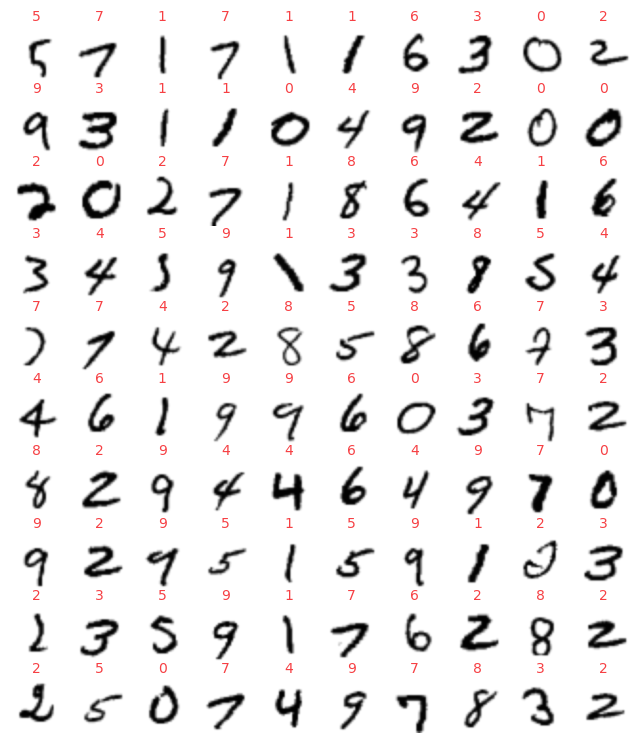

In [19]:
displayData(mnist_train.data[100:200], mnist_train.targets[100:200], class_value=True)

Target values

In [16]:
mnist_train.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

Target values one-hot encoded

In [17]:
torch.nn.functional.one_hot(mnist_train.targets[:10])

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [10]:
height = mnist_train.data.shape[1]
width = mnist_train.data.shape[2]
num_classes = mnist_train.targets.unique().shape[0]

Define data loaders to provide datasets batches during the training process

In [11]:
batch_size = 100

loaders = {'train' : DataLoader(mnist_train, batch_size=batch_size, shuffle=True),
            'test'  : DataLoader(mnist_test, batch_size=batch_size, shuffle=True)}

First approach: 
*   For each class, compute a linear combination of the ($28\times 28 =784$) values $x_i, i=1,\ldots, 784$ of the image, plus a constant (*bias*) $b$: that is, $785$ coefficients $w_1,\ldots, w_{784}, b$ must be defined for each class, for a total number of $785\times 10=7850$ coefficients
*   For each class, to the value resulting from the linear combination $$\sum_{i=1}^{784}w_ix_i+b$$ a suitable nonlinear function is applied (in this case the *exponential* function $e^{x}$)
*   The resulting values, one for each class, are *normalized* to sum to $1$
*   The result can be interpreted as a set of probabilities, associated to the set of disjoint events: the image belongs to the $i$-th class (it is a $0, 1, \ldots, 9$)
*   A strategy for assigning the image to a class can then be applied, such as assigning to the class of largest probability. In case, risk minimization approaches can be applied

In [131]:
class NeuralNet0(nn.Module):
    def __init__(self, w, h, num_classes):
         super(NeuralNet0, self).__init__()
         self.f = nn.Flatten()
         self.l1 = nn.Linear(w*h, num_classes)   
         self.ls = nn.LogSoftmax(dim=1)

    def forward(self, x):
         out = self.f(x)
         out = self.l1(out)
         out = self.ls(out)
         return out 

Create the network

In [132]:
model0 = NeuralNet0(height, width, num_classes)

In [133]:
summary(model0, input_size=(batch_size, height*width))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet0                               [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 10]                 7,850
├─LogSoftmax: 1-3                        [100, 10]                 --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

Define a loss function and a gradient descent method

In [134]:

learning_rate = 0.001

loss_func0 = nn.NLLLoss(reduction='sum')
optimizer0 = torch.optim.Adam(model0.parameters(), lr=learning_rate)

In [135]:
num_epochs = 3

In [136]:
h, h_batch = train(model0, loaders, loss_func0, num_epochs, optimizer0, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 0.6115, Training set accuracy 0.8567, Test set accuracy 0.9080
Epoch #2
............................................................xxxxxxxxxx 
 Loss 0.3431, Training set accuracy 0.9066, Test set accuracy 0.9166
Epoch #3
............................................................xxxxxxxxxx 
 Loss 0.3078, Training set accuracy 0.9153, Test set accuracy 0.9192


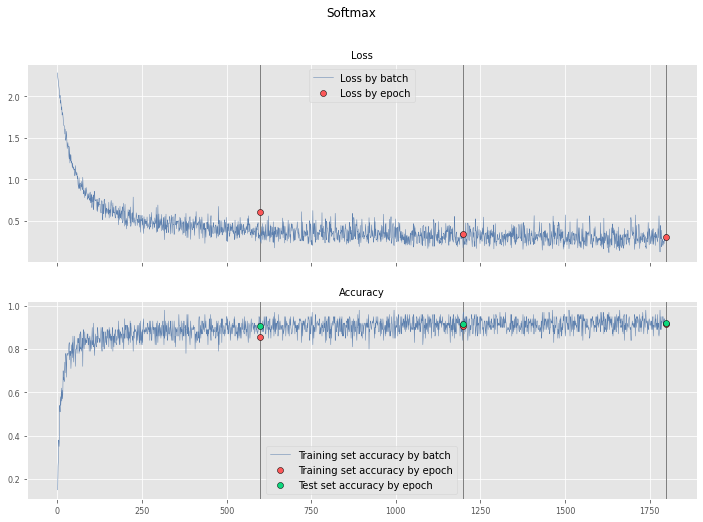

In [137]:
plot_metrics('Softmax', h, h_batch)


In [30]:
save_model_coeffs(model0, 'softmax')

Saved model coefficients to disk


In [33]:
load_model_coeffs(model0, 'softmax')

Model coefficients loaded from disk


In [138]:
ptr, ytr, pte, yte = predict(model0, loaders)

<Figure size 864x432 with 0 Axes>

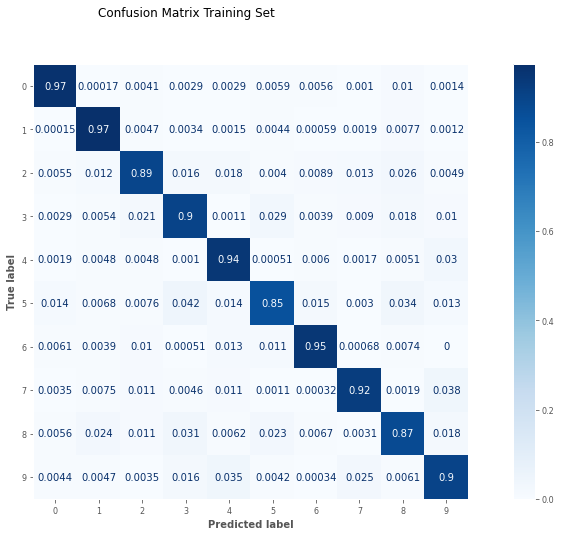

In [139]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()

Accuracy: $$\frac{\text{\# items classified correctly}}{\text{\# items}}$$

Precision class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items classified as class $i$}}$$

Recall class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items from class $i$}}$$

F-score class $i$: $$\frac{\text{Precision classe $i$} \times \text{Recall classe $i$}}{\text{Precision classe $i$}+\text{Recall classe $i$}}$$

In [215]:
print('Training set')
print(classification_report(ytr, ptr))

Training set
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5923
           1       0.96      0.96      0.96      6742
           2       0.91      0.88      0.89      5958
           3       0.90      0.86      0.88      6131
           4       0.90      0.91      0.91      5842
           5       0.85      0.85      0.85      5421
           6       0.93      0.95      0.94      5918
           7       0.94      0.92      0.93      6265
           8       0.85      0.86      0.86      5851
           9       0.86      0.89      0.87      5949

    accuracy                           0.91     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.91      0.91     60000



<Figure size 1200x600 with 0 Axes>

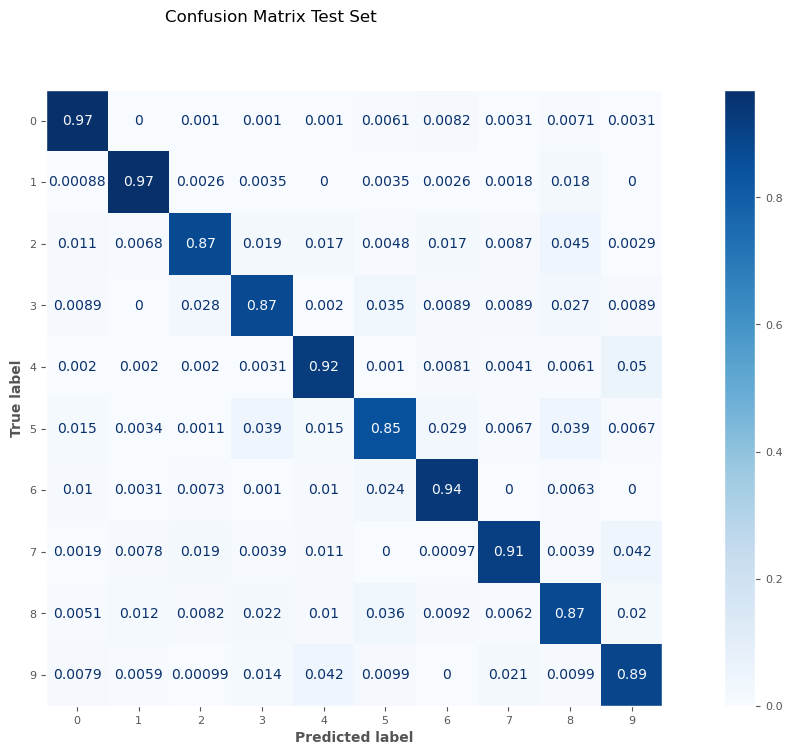

In [216]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()

In [218]:
print('Test set')
print(classification_report(yte, pte))

Test set
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.93      0.87      0.90      1032
           3       0.90      0.87      0.88      1010
           4       0.89      0.92      0.91       982
           5       0.86      0.85      0.85       892
           6       0.92      0.94      0.93       958
           7       0.94      0.91      0.92      1028
           8       0.84      0.87      0.86       974
           9       0.87      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.91     10000



In [40]:
X=next(iter(loaders['train']))[0]

In [42]:
X.numpy().shape

(100, 1, 28, 28)

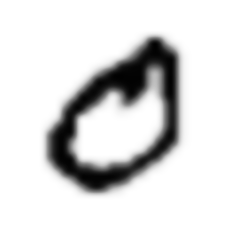

In [151]:
idx = 21
x = trans(mnist_train.data[idx,:,:].numpy())#.flatten(start_dim=0, end_dim=-1)
y = mnist_train.targets[idx].numpy()
image = mnist_train.data[idx,:,:].numpy()
plt.figure(figsize = (4,4))
plt.imshow(image, cmap='Greys', interpolation='quadric')
plt.grid(None)
plt.axis('off')
plt.show()

In [152]:
print(f"This is a {y}")

This is a 0


In [153]:
predict0 = model0(x)

predictions_probs = torch.exp(predict0).detach().squeeze()
predicted_class = np.squeeze(np.argmax(predictions_probs, axis=-1))
print("Predicted probabilities: ["+", ".join('%5.4f'%x for x in predictions_probs)+"]")
print(f"Class: {y}. Prediction: {predicted_class}")

Predicted probabilities: [0.9909, 0.0000, 0.0000, 0.0006, 0.0000, 0.0083, 0.0000, 0.0001, 0.0001, 0.0000]
Class: 0. Prediction: 0


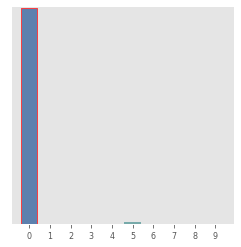

In [154]:
plot_label_dist(predictions_probs, predicted_class, y)

In [155]:
class NeuralNet1(nn.Module):
    def __init__(self, h, w, hidden_size, num_classes):
        super(NeuralNet1, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.ls(out)
        return out

In [156]:
hidden_size = 512
model1 = NeuralNet1(height, width, hidden_size, num_classes)

In [157]:
summary(model1)

Layer (type:depth-idx)                   Param #
NeuralNet1                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            401,920
├─ReLU: 1-3                              --
├─Linear: 1-4                            5,130
├─LogSoftmax: 1-5                        --
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0

In [158]:
learning_rate = 0.001

loss_func1 = nn.NLLLoss(reduction='sum')
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [159]:
num_epochs = 3

In [160]:
h, h_batch = train(model1, loaders, loss_func1, num_epochs, optimizer1, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 0.2952, Training set accuracy 0.9184, Test set accuracy 0.9559
Epoch #2
............................................................xxxxxxxxxx 
 Loss 0.1167, Training set accuracy 0.9665, Test set accuracy 0.9716
Epoch #3
............................................................xxxxxxxxxx 
 Loss 0.0754, Training set accuracy 0.9775, Test set accuracy 0.9740


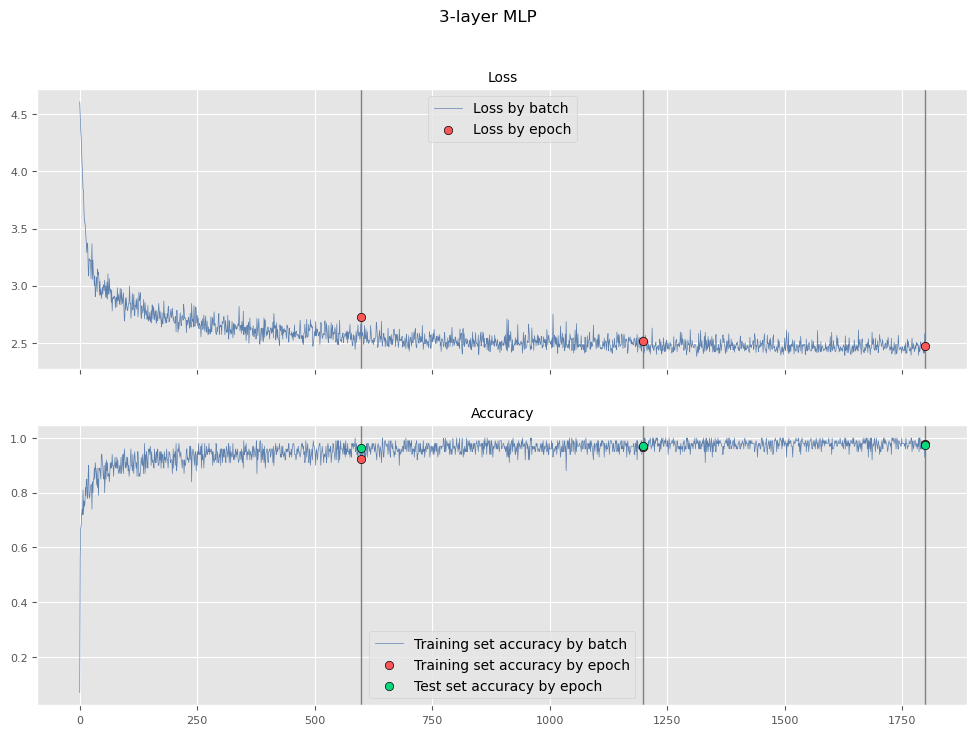

In [54]:
plot_metrics('3-layer MLP', h, h_batch)

In [55]:

ptr, ytr, pte, yte = predict(model1, loaders)


<Figure size 1200x600 with 0 Axes>

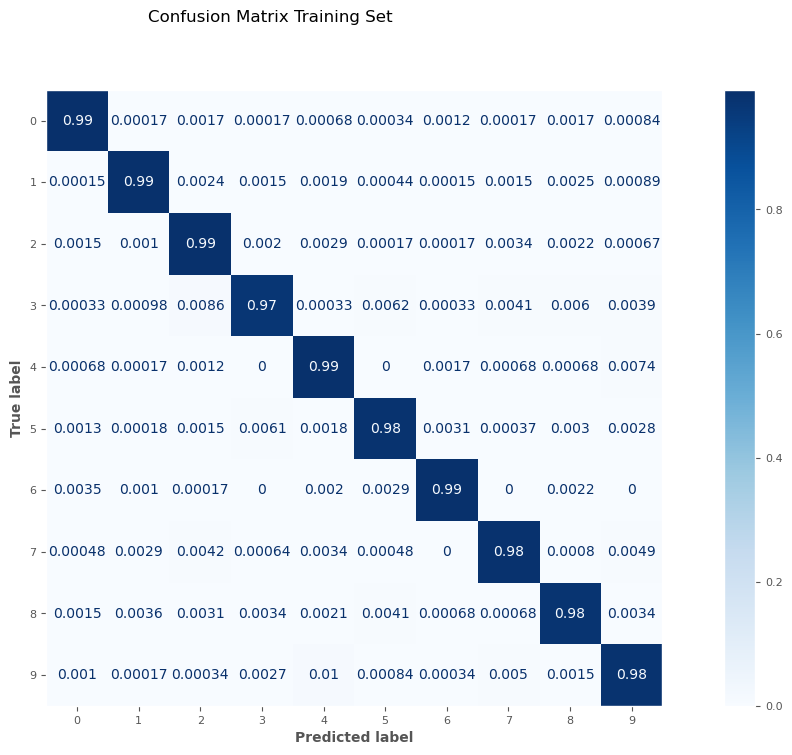

In [56]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()           

In [57]:
print('Training set')
print(classification_report(ytr, ptr))

Training set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.98      0.99      0.98      5958
           3       0.98      0.97      0.98      6131
           4       0.97      0.99      0.98      5842
           5       0.98      0.98      0.98      5421
           6       0.99      0.99      0.99      5918
           7       0.98      0.98      0.98      6265
           8       0.98      0.98      0.98      5851
           9       0.98      0.98      0.98      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



<Figure size 1200x600 with 0 Axes>

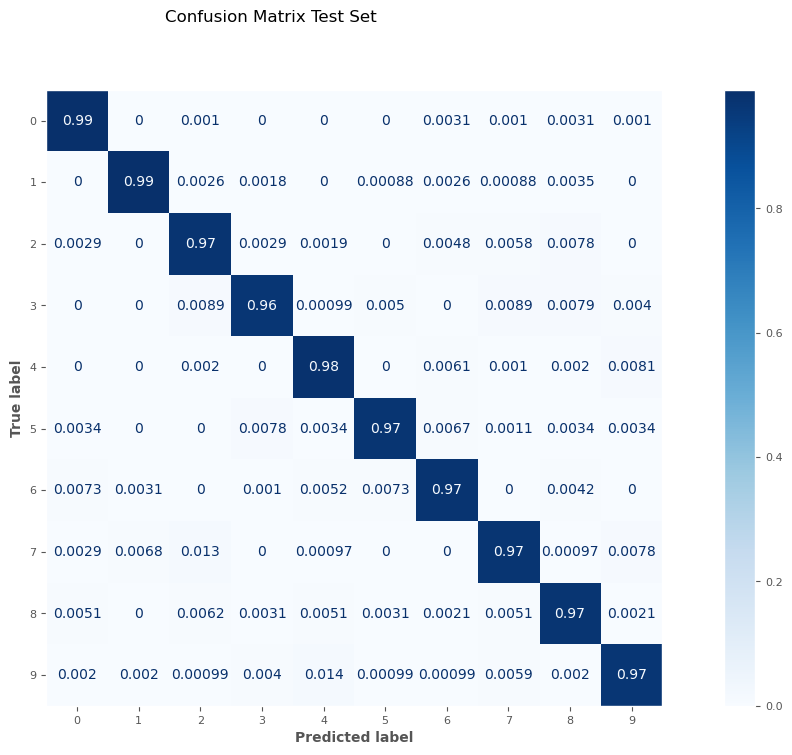

In [58]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()

In [59]:
print('Test set')
print(classification_report(yte, pte))

Test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.98       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [239]:
hidden_size1 = 512
hidden_size2 = 256

dropout_rate1 = .2
dropout_rate2 = .2


In [297]:
class NeuralNet2(nn.Module):
    def __init__(self, h, w, hidden_size1, hidden_size2, dropout_rate1, dropout_rate2, num_classes):
        super(NeuralNet2, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2) 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate2)
        self.l3 = nn.Linear(hidden_size2, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [302]:
model2 = NeuralNet2(height, width, hidden_size1, hidden_size2, dropout_rate1, dropout_rate2, num_classes)

In [303]:
s = 0
for name, param in model2.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

Parameter l1.weight, shape torch.Size([512, 784]), 401408 coefficients
Parameter l1.bias, shape torch.Size([512]), 512 coefficients
Parameter l2.weight, shape torch.Size([256, 512]), 131072 coefficients
Parameter l2.bias, shape torch.Size([256]), 256 coefficients
Parameter l3.weight, shape torch.Size([10, 256]), 2560 coefficients
Parameter l3.bias, shape torch.Size([10]), 10 coefficients
535818 coefficients overall


In [288]:
learning_rate = 0.001

loss_func2 = nn.NLLLoss(reduction='sum')
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [289]:
num_epochs = 3

In [304]:
h, h_batch = train(model2, loaders, loss_func2, num_epochs, optimizer2, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 4.6103, Training set accuracy 0.0732, Test set accuracy 0.0517
Epoch #2
............................................................xxxxxxxxxx 
 Loss 4.6103, Training set accuracy 0.0714, Test set accuracy 0.0536
Epoch #3
............................................................xxxxxxxxxx 
 Loss 4.6102, Training set accuracy 0.0720, Test set accuracy 0.0540


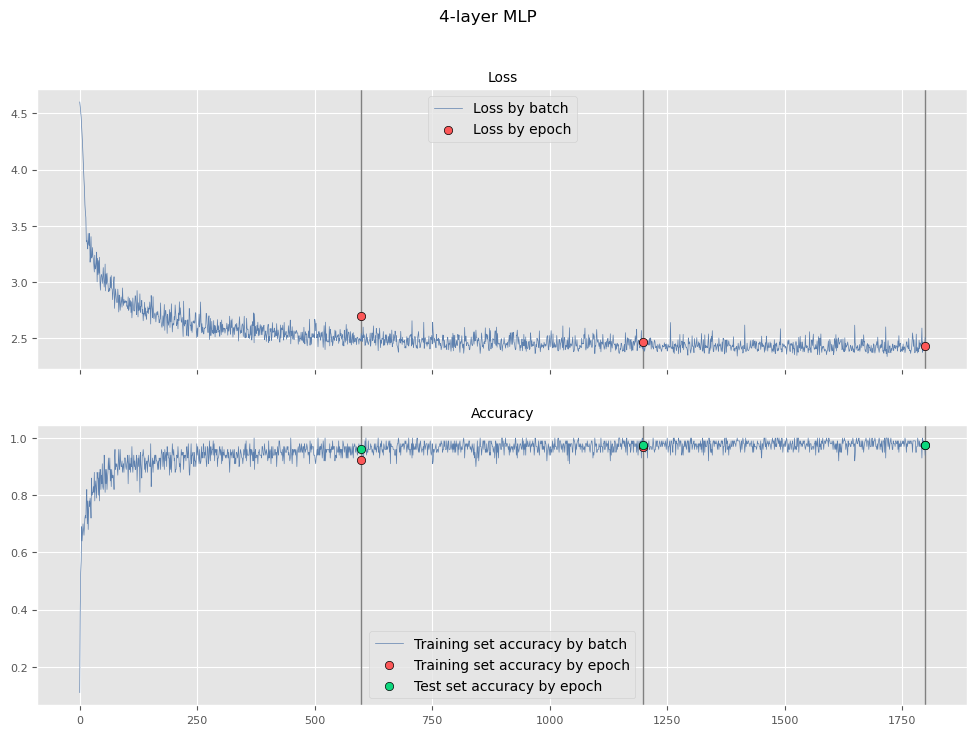

In [253]:
plot_metrics('4-layer MLP', h, h_batch)

In [254]:
ptr, ytr, pte, yte = predict(model2, loaders)

<Figure size 1200x600 with 0 Axes>

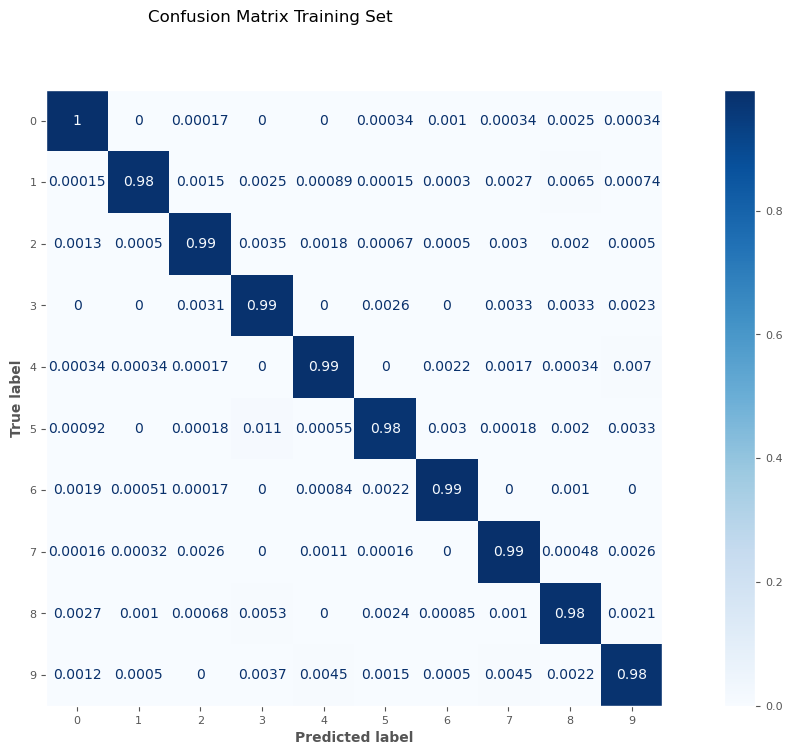

In [255]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()   

In [257]:
print('Training set')
print(classification_report(ytr, ptr))

Training set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5923
           1       1.00      0.98      0.99      6742
           2       0.99      0.99      0.99      5958
           3       0.98      0.99      0.98      6131
           4       0.99      0.99      0.99      5842
           5       0.99      0.98      0.98      5421
           6       0.99      0.99      0.99      5918
           7       0.98      0.99      0.99      6265
           8       0.98      0.98      0.98      5851
           9       0.98      0.98      0.98      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



<Figure size 1200x600 with 0 Axes>

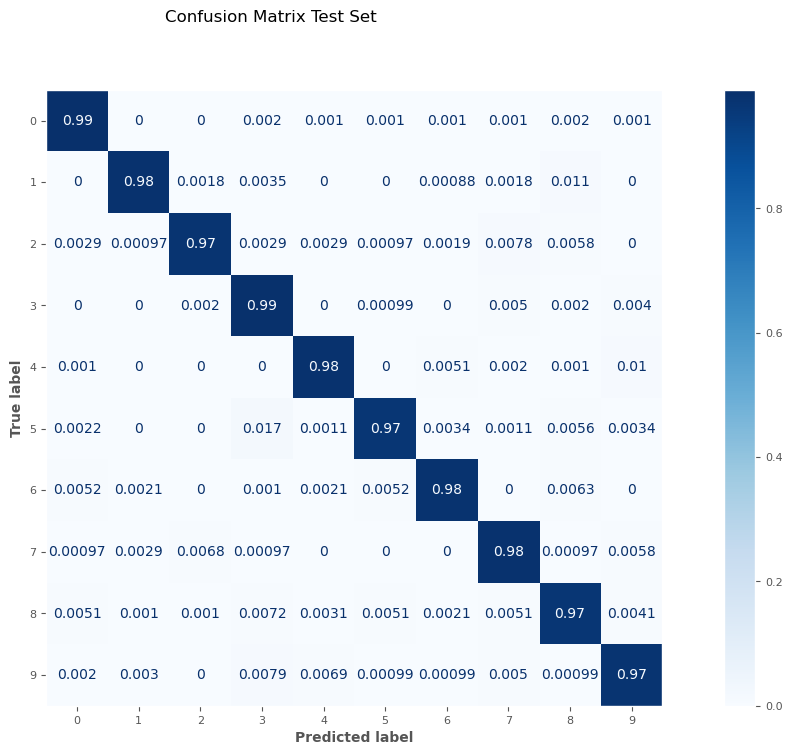

In [256]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()   

In [258]:
print('Test set')
print(classification_report(yte, pte))

Test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.96      0.97      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [23]:
class NeuralNet3(nn.Module):
    def __init__(self, n_channels, num_classes):
        super(NeuralNet3, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 4, 5)# input (1,28,28) output (4, 24, 24)
        self.bn1 = nn.BatchNorm2d(4)# input (4, 24, 24) output (4, 24, 24)
        self.relu1 = nn.ReLU()# input (4, 24, 24) output (4, 24, 24)
        self.pool1 = nn.MaxPool2d(2, 2)# input (4, 24, 24) output (4, 12, 12)
        self.conv2 = nn.Conv2d(4, 6, 3)# input (4, 12, 12) output (6, 10, 10)
        self.bn2 = nn.BatchNorm2d(6)# input (6, 10, 10) output (6, 10, 10)
        self.relu2 = nn.ReLU()# input (6, 10, 10) output (6, 10, 10)
        self.pool2 = nn.MaxPool2d(3, 2)# input (6, 10, 10) output (6, 4, 4)
        self.f = nn.Flatten()
        self.l1 = nn.Linear(6*4*4, 32) 
        self.relu1 = nn.ReLU()
        self.l3 = nn.Linear(32, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.f(out)
        out = self.l1(out)
        out = self.relu1(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [24]:
n_channels = 1
model3 = NeuralNet3(n_channels, num_classes)

In [58]:
print(model3)

NeuralNet3(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=96, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=10, bias=True)
  (ls): LogSoftmax(dim=0)
)


In [25]:
s = 0
for name, param in model3.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

Parameter conv1.weight, shape torch.Size([4, 1, 5, 5]), 100 coefficients
Parameter conv1.bias, shape torch.Size([4]), 4 coefficients
Parameter bn1.weight, shape torch.Size([4]), 4 coefficients
Parameter bn1.bias, shape torch.Size([4]), 4 coefficients
Parameter conv2.weight, shape torch.Size([6, 4, 3, 3]), 216 coefficients
Parameter conv2.bias, shape torch.Size([6]), 6 coefficients
Parameter bn2.weight, shape torch.Size([6]), 6 coefficients
Parameter bn2.bias, shape torch.Size([6]), 6 coefficients
Parameter l1.weight, shape torch.Size([32, 96]), 3072 coefficients
Parameter l1.bias, shape torch.Size([32]), 32 coefficients
Parameter l3.weight, shape torch.Size([10, 32]), 320 coefficients
Parameter l3.bias, shape torch.Size([10]), 10 coefficients
3780 coefficients overall


In [26]:
learning_rate = 0.001

loss_func3 = nn.NLLLoss(reduction='sum')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [27]:
num_epochs = 3

In [28]:
h, h_batch = train(model3, loaders, loss_func3, num_epochs, optimizer3, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 2.9040, Training set accuracy 0.8972, Test set accuracy 0.9596
Epoch #2
............................................................xxxxxxxxxx 
 Loss 2.5649, Training set accuracy 0.9627, Test set accuracy 0.9714
Epoch #3
............................................................xxxxxxxxxx 
 Loss 2.5038, Training set accuracy 0.9685, Test set accuracy 0.9737


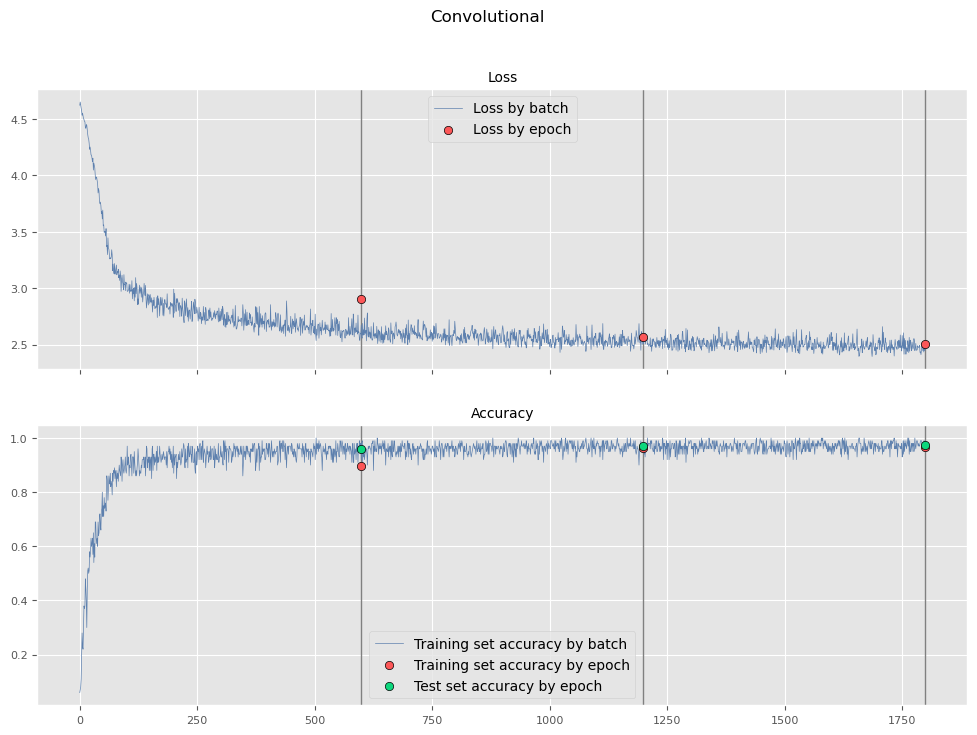

In [29]:
plot_metrics('Convolutional', h, h_batch)

In [30]:
ptr, ytr, pte, yte = predict(model3, loaders)

<Figure size 1200x600 with 0 Axes>

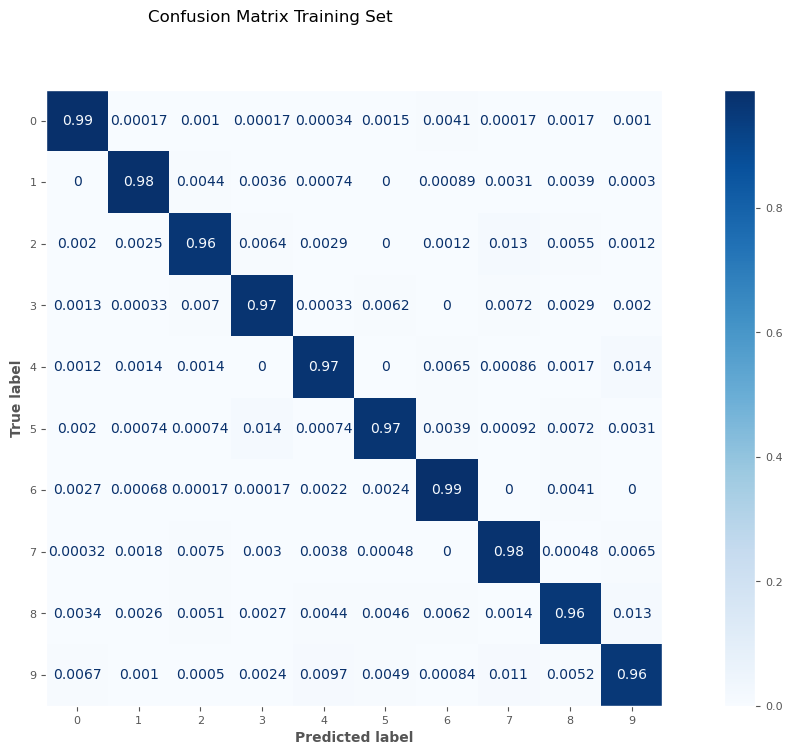

In [31]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()  

In [32]:
print('Training set')
print(classification_report(ytr, ptr))

Training set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5923
           1       0.99      0.98      0.99      6742
           2       0.97      0.96      0.97      5958
           3       0.97      0.97      0.97      6131
           4       0.97      0.97      0.97      5842
           5       0.98      0.97      0.97      5421
           6       0.98      0.99      0.98      5918
           7       0.96      0.98      0.97      6265
           8       0.97      0.96      0.96      5851
           9       0.96      0.96      0.96      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



<Figure size 1200x600 with 0 Axes>

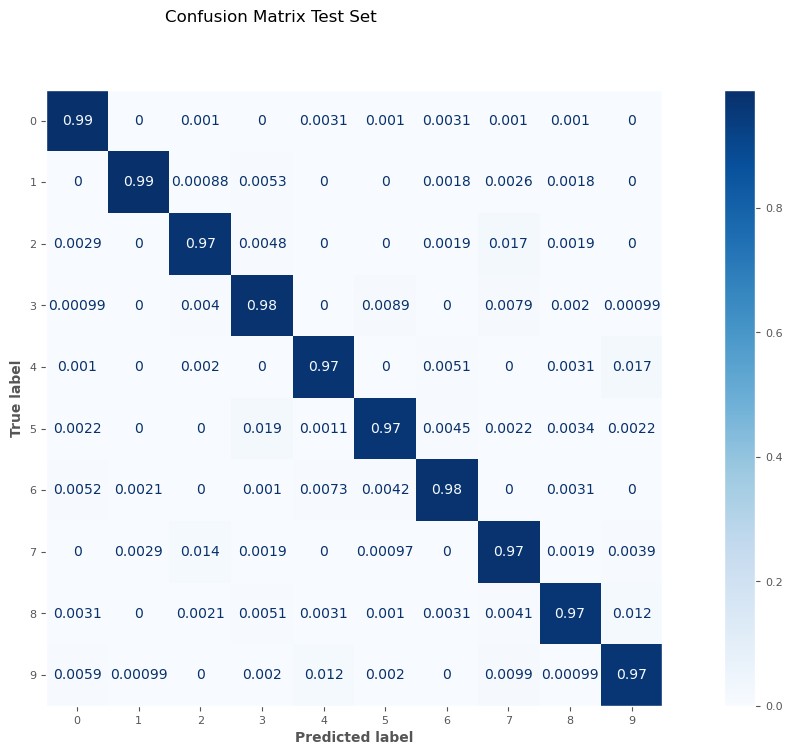

In [33]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()  

In [34]:
print('Test set')
print(classification_report(yte, pte))

Test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [35]:
class NeuralNet4(nn.Module):
    def __init__(self, n_channels, num_classes):
        super(NeuralNet4, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 12, kernel_size=3, stride=1, padding=2)# input (1,28,28) output (12, 30, 30)
        self.bn1 = nn.BatchNorm2d(12)# input (12, 30, 30) output (12, 30, 30)
        self.relu1 = nn.ReLU()# input (12, 30, 30) output (12, 30, 30)
        self.pool1 = nn.AvgPool2d(2, 2)# input (12, 30, 30) output (12, 15, 15)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)# input (12, 15, 15) output (6, 13, 13)
        self.bn2 = nn.BatchNorm2d(6)# input (6, 13, 13) output (6, 13, 13)
        self.relu2 = nn.ReLU()# input (6, 13, 13) output (6, 13, 13)
        self.f = nn.Flatten()# input (6, 13, 13) output (1014)
        self.d = nn.Dropout(p=.3)# input (1014) output (1014)
        self.l1 = nn.Linear(1014, 64)# input (1014) output (64)
        self.relu3 = nn.ReLU()# input (64) output (64)
        self.l3 = nn.Linear(64, num_classes)# input (64) output (10)
        self.ls = nn.LogSoftmax(dim=1)# input (10) output (10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.f(out)
        out = self.d(out)
        out = self.l1(out)
        out = self.relu3(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [36]:
n_channels = 1
model4 = NeuralNet4(n_channels, num_classes)

In [48]:
print_model_params(model4)

Parameter conv1.weight, shape torch.Size([12, 1, 3, 3]), 108 coefficients
Parameter conv1.bias, shape torch.Size([12]), 12 coefficients
Parameter bn1.weight, shape torch.Size([12]), 12 coefficients
Parameter bn1.bias, shape torch.Size([12]), 12 coefficients
Parameter conv2.weight, shape torch.Size([6, 12, 3, 3]), 648 coefficients
Parameter conv2.bias, shape torch.Size([6]), 6 coefficients
Parameter bn2.weight, shape torch.Size([6]), 6 coefficients
Parameter bn2.bias, shape torch.Size([6]), 6 coefficients
Parameter l1.weight, shape torch.Size([64, 1014]), 64896 coefficients
Parameter l1.bias, shape torch.Size([64]), 64 coefficients
Parameter l3.weight, shape torch.Size([10, 64]), 640 coefficients
Parameter l3.bias, shape torch.Size([10]), 10 coefficients
66420 coefficients overall


In [37]:
s = 0
for name, param in model4.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

Parameter conv1.weight, shape torch.Size([12, 1, 3, 3]), 108 coefficients
Parameter conv1.bias, shape torch.Size([12]), 12 coefficients
Parameter bn1.weight, shape torch.Size([12]), 12 coefficients
Parameter bn1.bias, shape torch.Size([12]), 12 coefficients
Parameter conv2.weight, shape torch.Size([6, 12, 3, 3]), 648 coefficients
Parameter conv2.bias, shape torch.Size([6]), 6 coefficients
Parameter bn2.weight, shape torch.Size([6]), 6 coefficients
Parameter bn2.bias, shape torch.Size([6]), 6 coefficients
Parameter l1.weight, shape torch.Size([64, 1014]), 64896 coefficients
Parameter l1.bias, shape torch.Size([64]), 64 coefficients
Parameter l3.weight, shape torch.Size([10, 64]), 640 coefficients
Parameter l3.bias, shape torch.Size([10]), 10 coefficients
66420 coefficients overall


In [38]:
learning_rate = 0.001

loss_func4 = nn.NLLLoss(reduction='sum')
optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [43]:
num_epochs = 2
h, h_batch = train(model4, loaders, loss_func4, num_epochs, optimizer4, report=True)

Epoch #1
............................................................xxxxxxxxxx 
 Loss 2.4413, Training set accuracy 0.9794, Test set accuracy 0.9843
Epoch #2
............................................................xxxxxxxxxx 
 Loss 2.4257, Training set accuracy 0.9817, Test set accuracy 0.9859


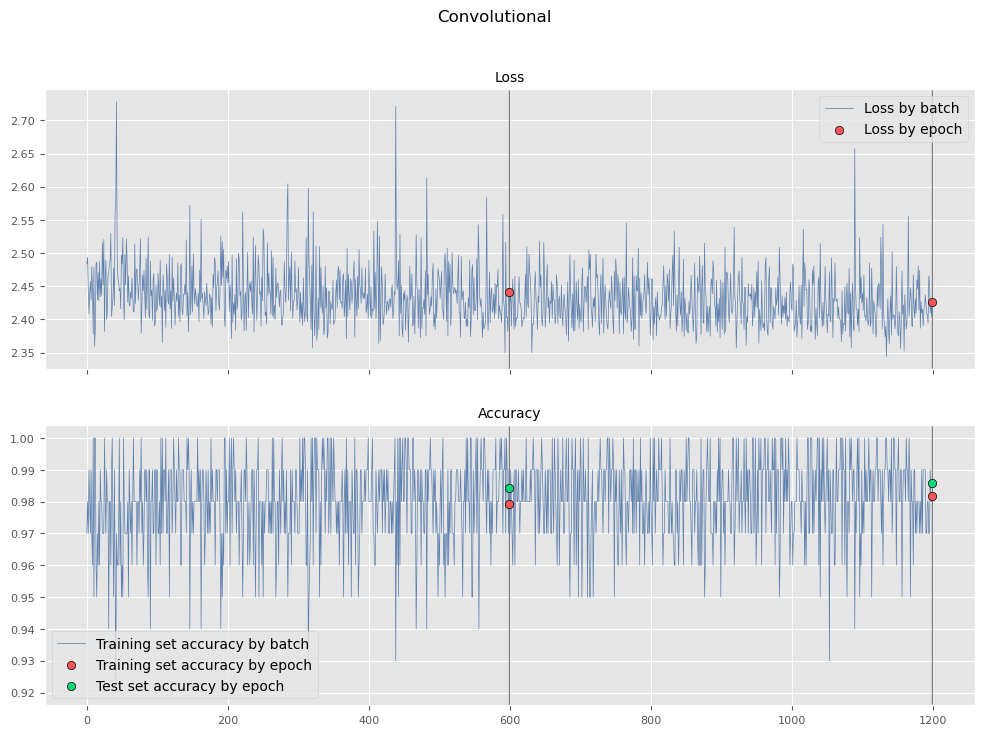

In [44]:
plot_metrics('Convolutional 2', h, h_batch)

In [45]:
ptr, ytr, pte, yte = predict(model4, loaders)

<Figure size 1200x600 with 0 Axes>

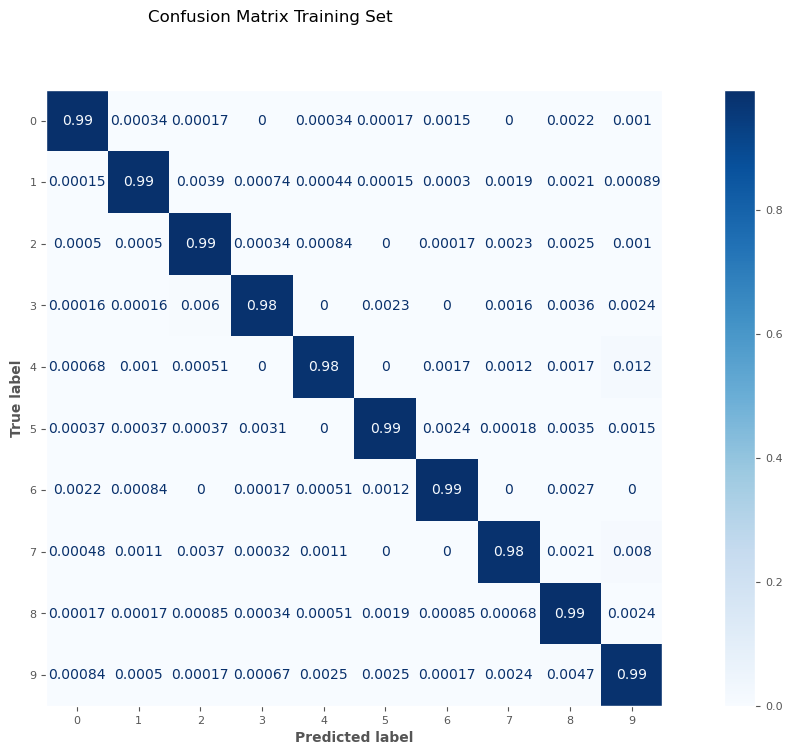

In [46]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()  

In [485]:
x0 = next(iter(loaders['train']))[0]
x1 = nn.ReLU()(nn.BatchNorm2d(12)(nn.Conv2d(n_channels, 12, kernel_size=3, stride=1, padding=2)(x0)))
x2 = nn.AvgPool2d(2,2)(x1)
x3 = nn.ReLU()(nn.BatchNorm2d(6)(nn.Conv2d(12, 6, kernel_size=3)(x2)))
#x4 = x3))
x5 = nn.Dropout(.3)(nn.Flatten()(x3))
x6 = nn.ReLU()(nn.Linear(1014, 32)(x5))
x7 = nn.LogSoftmax(dim=0)(nn.Linear(32, 10)(x6))

In [486]:
print(x0.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x5.shape)
print(x6.shape)
print(x7.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 12, 30, 30])
torch.Size([100, 12, 15, 15])
torch.Size([100, 6, 13, 13])
torch.Size([100, 1014])
torch.Size([100, 32])
torch.Size([100, 10])
